# Sparm Morphological Quality Prediction
Link : https://www.kaggle.com/competitions/sperm-morphological-quality/data

@YotaAI

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import models 
from torchvision.transforms import v2
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using : {device}')


import warnings
warnings.filterwarnings('ignore')

Using : cuda


In [2]:
high_quality_path = "/kaggle/input/sperm-morphological-quality/Sperm-Data/High Quality Sperm - Labeled"
low_quality_path = "/kaggle/input/sperm-morphological-quality/Sperm-Data/Low Quality Sperm - Unlabeled"
bad_dataset = "/kaggle/input/sperm-morphological-quality/Sperm-Data/High Quality Sperm - Labeled/Bad Sperm"
good_dataset = "/kaggle/input/sperm-morphological-quality/Sperm-Data/High Quality Sperm - Labeled/Good Sperm"
load_model=True
model_path= "/kaggle/working/unet_model.pt"
optimizer_path = "/kaggle/working/optimizer.pt"

In [3]:
dataset = pd.DataFrame({
    'category': ['Good','Bad'],
    'Count': [len(os.listdir(good_dataset)), len(os.listdir(bad_dataset))]
})
dataset

,category,Count
0,Good,486
1,Bad,3656


# Visualization

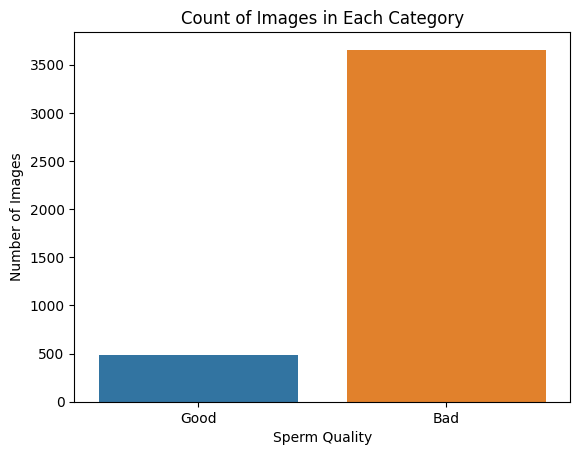

In [4]:
sns.barplot(data=dataset,x='category',y='Count')
plt.title('Count of Images in Each Category')
plt.xlabel('Sperm Quality')
plt.ylabel('Number of Images')
plt.show()

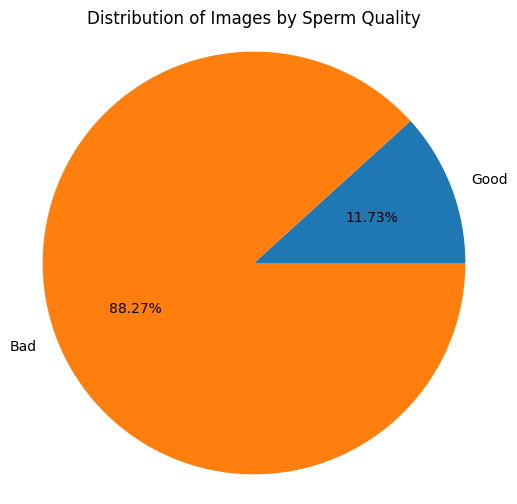

In [5]:
plt.figure(figsize=(6,6))
plt.pie(dataset['Count'],labels=dataset['category'],autopct='%1.2f%%')
plt.title('Distribution of Images by Sperm Quality')
plt.axis('equal')  
plt.show()

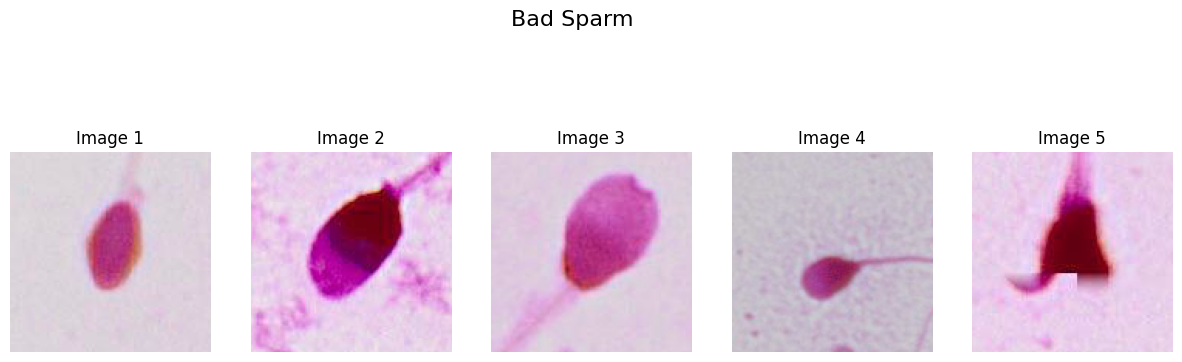

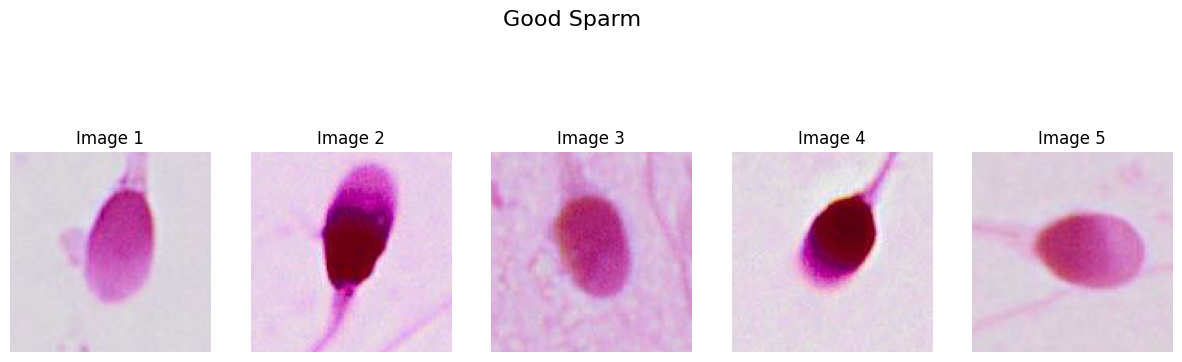

In [6]:
def display_images_from_folder(folder_path, num_images=5, title=""):
    image_files = os.listdir(folder_path)[:num_images]
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")

    plt.show()
display_images_from_folder(bad_dataset,title="Bad Sparm")
display_images_from_folder(good_dataset,title="Good Sparm")

In [7]:
sparm_dataset = []
positive = []
for file in os.listdir(good_dataset):
    positive.append([os.path.join(good_dataset,file),'Good'])
    
for file in os.listdir(bad_dataset):
    sparm_dataset.append([os.path.join(bad_dataset,file),'Bad'])
sparm_dataset+=8*(positive)
sparm_dataset=pd.DataFrame(sparm_dataset,columns=['Path','Quality'])
sparm_dataset.replace({"Quality": {"Good":1,"Bad":0}},inplace=True)

In [8]:
new_quantity = sparm_dataset.groupby(by='Quality').count()
new_quantity['Quality']=new_quantity.index
new_quantity

,Path,Quality
Quality,,
0,3656,0
1,3888,1


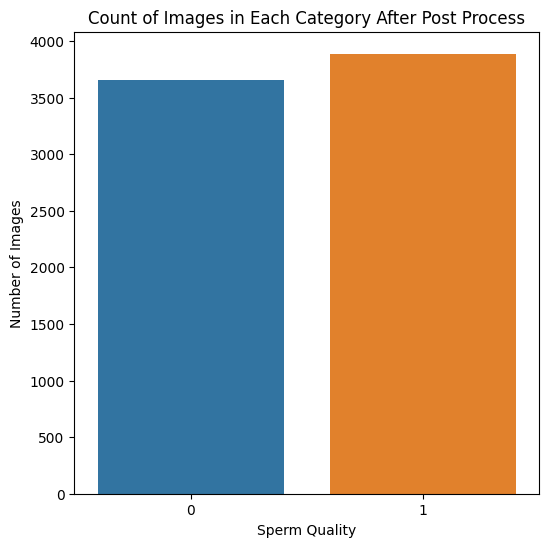

In [9]:
plt.figure(figsize=(6,6))
sns.barplot(data=new_quantity,y='Path',x='Quality')
plt.title('Count of Images in Each Category After Post Process')
plt.xlabel('Sperm Quality')
plt.ylabel('Number of Images')
plt.show()

## Model and Dataset

In [10]:
from sklearn.model_selection import train_test_split
class Dataset(torch.utils.data.Dataset):
    def __init__(self,dataset,train=True,image_dim=256,transform=None):
        super().__init__()
        self.image_dim=image_dim
        self.transform=transform
        x_train,x_test,y_train,y_test = train_test_split(dataset.Path.values,dataset.Quality.values,shuffle=True,test_size=0.1,random_state=42)
        if train:
            self.x,self.y=x_train,y_train
        else:
            self.x,self.y=x_test,y_test
            
        self.good_transform = v2.Compose([
            
            v2.RandomHorizontalFlip(0.5),
            v2.RandomVerticalFlip(0.5),
            v2.RandomRotation(180),
        ])
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        image = Image.open(self.x[idx])
        y = torch.tensor(self.y[idx]).unsqueeze(0).to(torch.float32)
        label = torch.zeros([1,self.image_dim,self.image_dim])
        label+=y
        if y==1:
            image = self.good_transform(image)
        if self.transform:
            image = self.transform(image)
        
        return (image,label)

In [11]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)
    
    
# model = UNet(3,1).to(device)

# summary(model,(3,224,224))

In [13]:

image_dim=224
batch_size=16
num_epoch=100
learning_rate=0.01
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.Resize(size=(image_dim, image_dim), antialias=True),  # Or Resize(antialias=True)
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = Dataset(sparm_dataset,image_dim=image_dim,train=True,transform=transforms) 
test_ds = Dataset(sparm_dataset,image_dim=image_dim,train=False,transform=transforms) 
train_loader=torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False
)

# base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = UNet(3,1).to(device)

loss_fn = nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

if load_model:
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))  
    print("Model Loaded Successfully....")

# for group in optimizer.param_groups:
#     group['lr'] = 0.0001
    
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Model Loaded Successfully....


## Training

In [15]:
def train_one_epoch(epoch,train_loader):
    model.train()
    loader = tqdm(train_loader)
    running_loss = 0
    for idx,(x,y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        
        
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss +=loss.item()
        
        loader.set_postfix(loss = running_loss/(idx+1))
    
    return running_loss/len(train_loader)
    
def eval_one_epoch(test_loader):
    model.eval()
    total_loss = 0
    for idx,(x,y) in enumerate(tqdm(test_loader)):
        x=x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        total_loss+=loss.item()
#         if idx==1:
#             print(y.flatten().detach().cpu(),y_pred.flatten().detach().cpu())
    return total_loss / len(test_loader)

        

In [16]:
#Training
min_loss=10
train_losses = []
test_losses = []
epoch=0

In [17]:
from IPython.display import clear_output
while epoch<num_epoch:
    epoch+=1
    model.train()
    train_loss = train_one_epoch(epoch,train_loader)
    test_loss = eval_one_epoch(test_loader)
    scheduler.step()
    print(f'@ Epoch {epoch} \nTraining Loss : {train_loss}')
    print(f'Testing Loss  : {test_loss}')
    print('--------------------------------')
    train_losses.append(train_loss)
    test_losses.append(test_loss)
#     clear_output(wait=True) 
    if test_loss < min_loss:
        min_loss=test_loss
        torch.save(model.state_dict(),'unet_model.pt')
        torch.save(optimizer.state_dict(),'optimizer.pt')

100%|██████████| 48/48 [00:10<00:00,  4.43it/s]


@ Epoch 1 
Training Loss : 0.0399367114430403
Testing Loss  : 0.02840000570965155
--------------------------------


100%|██████████| 48/48 [00:07<00:00,  6.51it/s]


@ Epoch 2 
Training Loss : 0.03528543259510222
Testing Loss  : 0.027333774172196474
--------------------------------


100%|██████████| 48/48 [00:07<00:00,  6.42it/s]


@ Epoch 3 
Training Loss : 0.040537936144015366
Testing Loss  : 0.038830816389236134
--------------------------------


100%|██████████| 48/48 [00:07<00:00,  6.23it/s]


@ Epoch 4 
Training Loss : 0.036990133386434004
Testing Loss  : 0.050300715141929686
--------------------------------


100%|██████████| 48/48 [00:07<00:00,  6.59it/s]


@ Epoch 5 
Training Loss : 0.0374375628564945
Testing Loss  : 0.029369739567452296
--------------------------------


 16%|█▌        | 67/425 [00:22<01:58,  3.01it/s, loss=0.0449]


KeyboardInterrupt: 

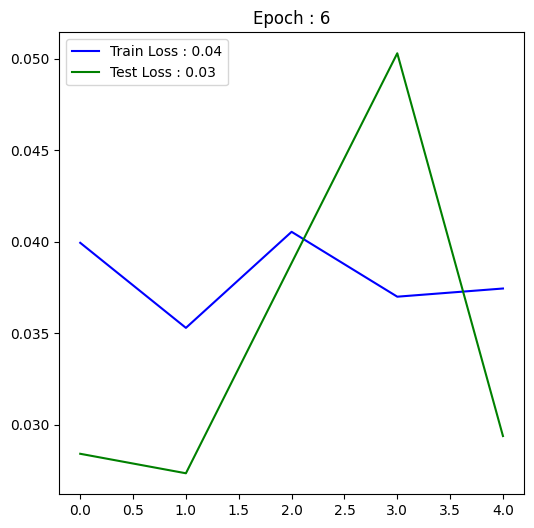

In [18]:
plt.figure(figsize=(6,6))
plt.title(f"Epoch : {epoch}")
plt.plot(train_losses,label=f'Train Loss : {sum(train_losses)/len(train_losses):.2f}', color='b')
plt.plot(test_losses,label=f'Test Loss : {sum(test_losses)/len(test_losses):.2f}', color='g')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

## Visualization Prediction

In [22]:
model.eval()
total_loss = 0
outputs = []
for idx,(x,y) in enumerate(tqdm(test_loader)):
    x=x.to(device)
    with torch.no_grad():
        y_pred = model(x).cpu()
    for i in range(x.size(0)):
        outputs.append([y[i].max().item(),y_pred[i].max().item()])
    


100%|██████████| 48/48 [00:07<00:00,  6.12it/s]


In [82]:
df = pd.DataFrame(outputs,columns=['Original','Predicted'])
df.Predicted[df['Predicted']<=0.99]=0
df.Predicted[df['Predicted']>0.99]=1

In [83]:
df

,Original,Predicted
0,0.0,0.0
1,0.0,0.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
...,...,...
750,1.0,1.0
751,0.0,0.0
752,1.0,1.0
753,1.0,1.0


In [84]:
org = torch.from_numpy(df.Original.values)
pred = torch.from_numpy(df.Predicted.values)

In [88]:
df.Original[df.Original!=df.Predicted]

18     1.0
40     1.0
274    0.0
276    0.0
347    1.0
Name: Original, dtype: float64